__Testing b_star and its connection with phase transitions__

Ingnore code, read comments under the pictures.

In [3]:
import sys
sys.path.append("..")
from multiprocessing import Pool
import numpy as np
from graph import Circle, Grid, RandomRegular, GraphByDegrees, ErdosRenyi
from b_star import get_b_stars
from viz import draw_data
from utils import Timer, partition
from engine import fun
from engine_mono import fun_mono
from engine_sum import fun_sum
from engine_single import fun_single
from graph_toolset import coreness
import jupyternotify
import random
ip = get_ipython()
ip.register_magics(jupyternotify.JupyterNotifyMagics)
import matplotlib.pyplot as plt
%matplotlib notebook

<IPython.core.display.Javascript object>

In [4]:
def total(graph, keys):
    if 'total' in keys:
        return {'total': graph.nodes}
    else:
        return {}

In [5]:
def calc(fun_name, alphas, bs, graphs, T, init_type='01', set_builder=total, keys=['total'], pool_size=32):
    pool = Pool(pool_size)
    
    res = dict()
    for key in keys:
        res[key] = []

    timer = Timer()
    
    now = 0
    
    for graph in graphs:
        local_timer = Timer()
        
        sets = set_builder(graph, keys)
        
        points = [(graph, b, alpha, T, init_type, sets) for alpha in alphas for b in bs]
        
        if fun_name == 'fun':
            cur = pool.map(fun, points)
        elif fun_name == 'mono':
            cur = pool.map(fun_mono, points)
        elif fun_name == 'sum':
            cur = pool.map(fun_sum, points)
        elif fun_name == 'single':
            cur = pool.map(fun_single, points)
        else:
            raise Exception(f'dont know fun name {fun_name}!')
        
        for key in keys:
            tmp = []
            for step in cur:
                tmp.append(step[key])
            
            tmp = np.array(tmp)
            tmp = np.reshape(tmp, (len(alphas), len(bs), tmp.shape[1]))
            res[key].append(tmp)
        
        t = local_timer.measure()
        now += 1
        rem = len(graphs) - now
        print(f'#{now} passed in {local_timer.measure()},  projected end in {timer.measure() / now * rem / 60} minutes', flush=True)
        
    for key in keys:
        res[key] = np.array(res[key])
        
    timer.print_elapsed()
    
    return res

In [16]:
def cut_alpha(data, alpha_id=0):
    res = dict()
    for key, arr in data.items():
        res[key] = arr[:, alpha_id, :, :]
    return res

In [27]:
def plot_means(ax, bs, data, last, keys, title, show_data=True):
    for key in keys:
        cur = np.apply_along_axis(np.mean, 2, data[key][:, :, -last:])
        if show_data:
            for t in cur:
                ax.scatter(bs, t, s=1, alpha=.05)

        cur = np.apply_along_axis(np.mean, 0, cur)
        ax.plot(bs, cur, '-', label=f'{key}')
    ax.legend()
    ax.set_title(title)

In [8]:
def plot_individual(data, prob, keys, title):
    fig, ax = plt.subplots()
    
    for key in keys:
        for i in range(data[key].shape[0]):
            for j in range(data[key].shape[1]):
                for k in range(data[key].shape[2]):
                    if random.uniform(0, 1) < prob:
                        ax.plot(data[key][i][j][k])
    ax.set_title(title)
    plt.show()

In [9]:
def get_er(_):
    return ErdosRenyi(1000, 4. / 1000.)

graphs_er = Pool(32).map(get_er, [() for _ in range(500)])

In [10]:
def degs(graph, keys=[]):
    sets = dict()
    for key in keys:
        sets[key] = []
    
    for v in graph.nodes:
        d = graph.deg(v)
        if d not in keys:
            continue
        sets[d].append(v)
    return sets

In [34]:
def plot_ratios(ax, graph, scale=1):
    ratios = get_b_stars(graph)
    ratios = {k: v for k, v in ratios.items() if 1 < k <= 10}
    total = sum(ratios.values())
    ratios = {k: v / total * scale for k, v in ratios.items()}
    ax.hist(list(ratios.keys()), weights=list(ratios.values()), bins=100)

In [24]:
res = calc('fun', [.1], partition(0, 10, 256), graphs_er[0:1]*10, 200, set_builder=total, keys=['total'])

#1 passed in 45.98750400543213,  projected end in 6.898131394386292 minutes
#2 passed in 46.2032630443573,  projected end in 6.146190404891968 minutes
#3 passed in 47.017863512039185,  projected end in 5.413801933659448 minutes
#4 passed in 46.452932834625244,  projected end in 4.641650468111038 minutes
#5 passed in 46.508835554122925,  projected end in 3.869596735636393 minutes
#6 passed in 45.58975410461426,  projected end in 3.0862939569685195 minutes
#7 passed in 45.54998207092285,  projected end in 2.309409495762416 minutes
#8 passed in 46.09189224243164,  projected end in 1.5392096092303593 minutes
#9 passed in 46.7619833946228,  projected end in 0.7706912159919739 minutes
#10 passed in 46.031532764434814,  projected end in 0.0 minutes
time elapsed = 462.20946741104126


<IPython.core.display.Javascript object>


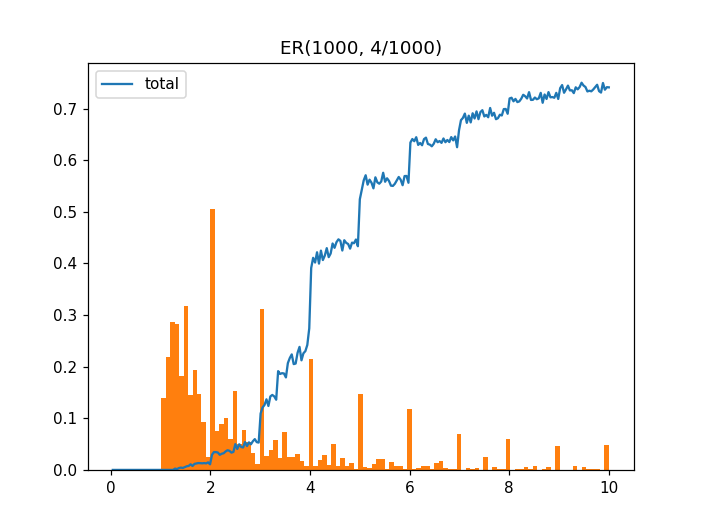

In [35]:
fig, ax = plt.subplots() 
plot_means(ax, partition(0, 10, 256), cut_alpha(res), 20, ['total'], 'ER(1000, 4/1000)', show_data=False)
plot_ratios(ax, graphs_er[0], scale=5)
plt.show()

On the plot above, we can see that in Erods-Renyi model, phase transitions are indeed correlate with frequency, with which each b_star is plotted

In [40]:
graph23 = GraphByDegrees({2: 500, 3: 500})
res23 = calc('fun', [.1], partition(0, 10, 256), [graph23]*10, 1000, set_builder=total, keys=['total'])

#1 passed in 182.33796191215515,  projected end in 27.350699651241303 minutes
#2 passed in 185.40719389915466,  projected end in 24.516569821039834 minutes
#3 passed in 185.9355583190918,  projected end in 21.532199541727703 minutes
#4 passed in 185.0185718536377,  projected end in 18.467616415023805 minutes
#5 passed in 184.58826971054077,  projected end in 15.388230395317077 minutes
#6 passed in 188.00131368637085,  projected end in 12.347735860612657 minutes
#7 passed in 184.0427269935608,  projected end in 9.2524288552148 minutes
#8 passed in 184.90631890296936,  projected end in 6.167698047558466 minutes
#9 passed in 182.54836297035217,  projected end in 3.079253893428379 minutes
#10 passed in 184.20623421669006,  projected end in 0.0 minutes
time elapsed = 1847.015585899353


<IPython.core.display.Javascript object>


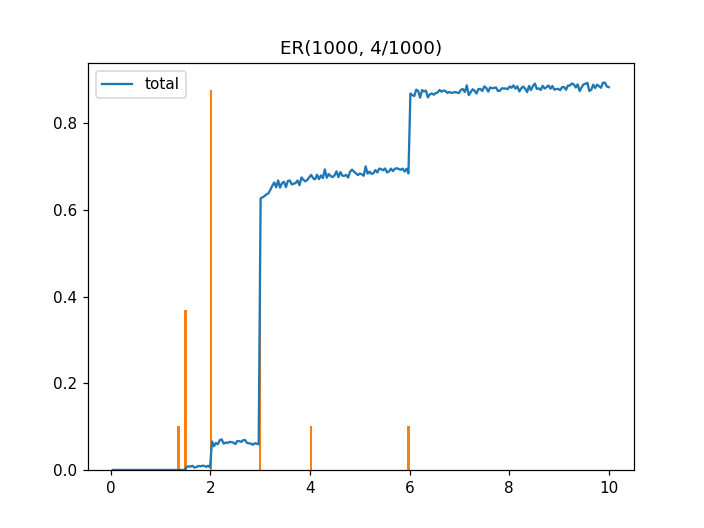

In [41]:
fig, ax = plt.subplots() 
plot_means(ax, partition(0, 10, 256), cut_alpha(res23), 200, ['total'], 'ER(1000, 4/1000)', show_data=False)
plot_ratios(ax, graph23, scale=2)
plt.show()